In [62]:
import  math
import numpy as np
import matplotlib.pyplot as plt
from anyio.abc import value
%matplotlib inline

In [63]:
def f(x):
    return 3*x**2 - 4*x + 5

In [64]:
f(3.0)

20.0

In [65]:
xs = np.arange(-5 , 5 , 0.25) # this generates us an array with numbers from -5 to 5 with step value of 0.25
ys = f(xs)                      # this will give an array that as each entry as the function applied on it
plt.plot(xs, ys)

 Now we wanna know the derivatives at a certain point x.
 
now, like the last one where we manually derived the derivatives needed for backpropagation it was really time consuming and not at all viable for a larger nn. So to tackle this we would need to come up with a better approach.


what derivative really is that it tells us what happens if we slightly bump up our x by h, what sensitivity it responds with.


In [66]:
h = 0.000001
x = 2/3
(f(x+h) - f (x)) / h

2.999378523327323e-06

In [67]:
h = 0.0001

# Inputs..
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# getting derivative wrt to a
a += h
d2 = a*b + c
print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Slope: {(d1-d2)/h}")

d1: 4.0
d2: 3.999699999999999
Slope: 3.000000000010772


In [99]:
class Value():
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.label = label
        self.grad = 0.0 # this means initially it is not affected by anything
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
            
        out._backward = _backward
            
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
            
        return out 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/floats"
        out = Value(self.data**other,(self,other),f'**{other}')
        
        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return other * self
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other)
    
    def tanh(self): #purpose of this is to act as an activation function for our neurons output
        x = self.data
        o = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(o, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - o**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        o = math.exp(x)
        out = Value(o, (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward        
        return out
            
        
        
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                    
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
        


In [101]:
a = Value(2.0)
b = 4
b - a

TypeError: unsupported operand type(s) for -: 'int' and 'Value'

### Lets Import a library to draw a flowchart of the tree representation of dependencies of the variable


In [71]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set() # make a set to store all nodes and edges
  def build(v):
    if v not in nodes: # if node not currently found we add it
      nodes.add(v)
      for child in v._prev: # recursively backtrack looking for nodes that make up the current node
        edges.add((child, v))
        build(child) # now apply this on the childs
  build(root)  # apply it to solo nodes
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  # define the formatting of the nodes and graph
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n)) # iterate over all nodes and then give them a unique id for representating it
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

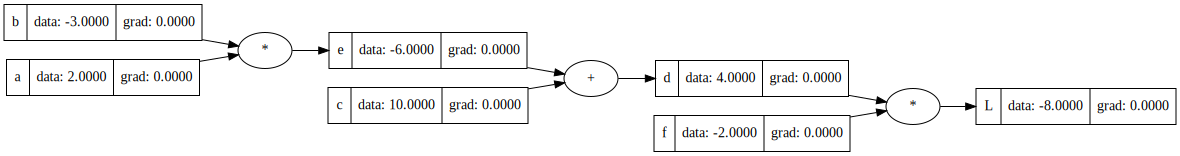

In [72]:
draw_dot(L)

In [73]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
b.grad = 2.0 * (-2.0)
a.grad = -3.0 * (-2.0)


- a = Value(2.0, label='a')
- b = Value(-3.0, label='b')
- c = Value(10.0, label='c')
- e = a*b; e.label = 'e' -------> -6
- d = e + c; d.label = 'd' --------> 4
- f = Value(-2.0, label='f') ------> -2
- L = d * f; L.label = 'L' -------> -8

**now, gradients will be calculated**
- dL/dL = 1
- dL/df = d
- dL/dd = f
- dL/de = (dL/dd)* (dd/de) = f*1 = f
- dL/dc = (dL/dd) * (dd/dc) = f*1 = f
- dL/db = (dL/de)*(de/db) = f * a
- dL/da = (dL/de)*(de/da) = f * b


In [74]:
def lol(): # use this to find derivatives and verify
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


To increase value of L we move in the direction of gradient.
if we nudge all the values L depends on in direction of gradient we will be able to increase L to maximize it.

In [75]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


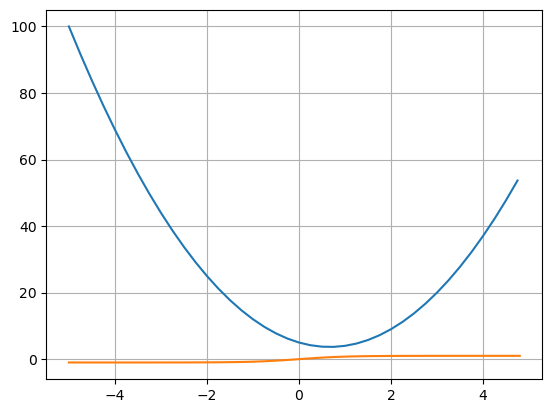

In [76]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); # our activation function for neurons
plt.show()

In [77]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # The vid choose this bias so that values come out proper to better understand gradient
# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o= n.tanh(); o.label = 'o'

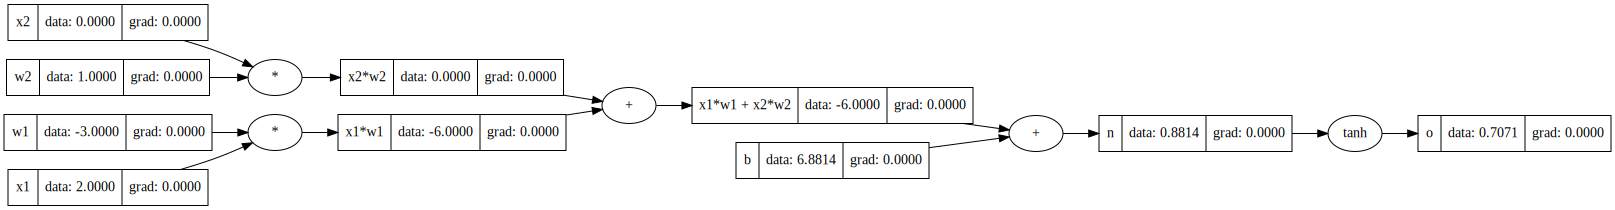

In [78]:
draw_dot(o)

Now, We manually backpropagate and calculate the gradients

In [79]:
o.grad = 1
# now backpropagation 

n.grad = 1 - o.data ** 2 # pass through tanh so need to take derivative of that and then compute

x1w1x2w2.grad = n.grad # passes through + operator so the constant terms go 0 and we left with grad of current node

b.grad = n.grad # passes through + operator so the constant terms go 0 and we left with grad of current node

x2w2.grad = x1w1x2w2.grad # passes through + operator so the constant terms go 0 and we left with grad of current node

x1w1.grad = x1w1x2w2.grad # passes through + operator so the constant terms go 0 and we left with grad of current node

x2.grad = w2.data * x2w2.grad # passes through * operator so the coefficient is multiplied with the current node's grad

w2.grad = x2.data * x2w2.grad # passes through * operator so the coefficient is multiplied with the current node's grad

x1.grad = w1.data * x1w1.grad # passes through * operator so the coefficient is multiplied with the current node's grad

w1.grad = x1.data * x1w1.grad # # passes through * operator so the coefficient is multiplied with the current node's grad


In [80]:
# o = tanh(n)
# do/dn = 1 - tanh(n)^2 = 1 - o^2

All this is too hectic and not feasible in case of a larger network so its essential for us to automate this on creation.

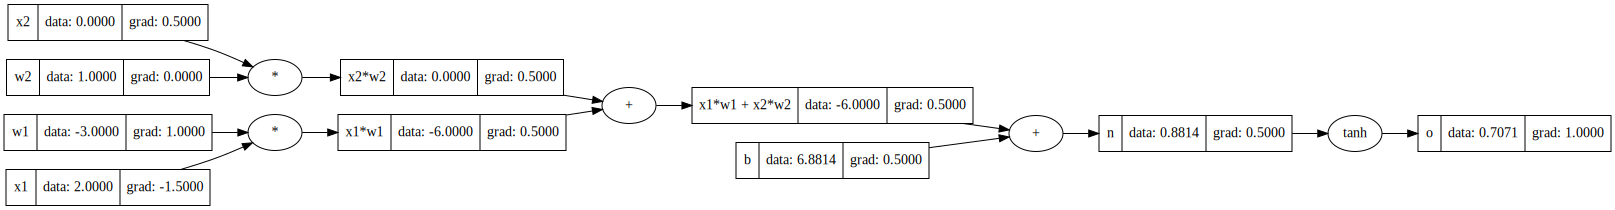

In [81]:
draw_dot(o)

In [82]:
o.grad = 1.0 #initialize the base case

In [83]:
# now backtrack and call  _backward function to get gradient of prev node, maintain the order (essential)
o._backward()

In [84]:
n._backward()

In [85]:
x1w1x2w2._backward()

In [86]:
x2w2._backward()
x1w1._backward()

This is better since we dont have to manually calculate the gradient, it does that itself.

but a limitation for this is if we have a large number of nodes, calling _backward method manually will be really time consuming.

so lets try and automate the backward function

#### We would want a sorting of the nodes in a way they point in a single direction, ideally left to right.
#### We would want to call backward on a node only when it has been called on all the nodes on its right that are its dependencies

In [87]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # The vid choose this bias so that values come out proper to better understand gradient
# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o= n.tanh(); o.label = 'o'

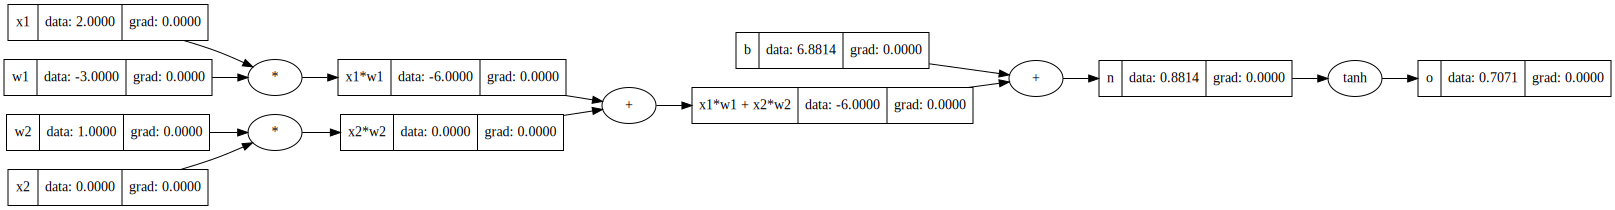

In [88]:
draw_dot(o)

In [89]:
o.backward()

### This approach is good.
but there is an underlying bug that we have not come across, lets look into that

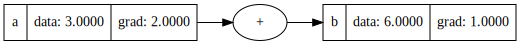

In [90]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

We see that b = a + a, finding db/da we see db/da = 2 but its stored as 1.
error is at place where we defined the operations

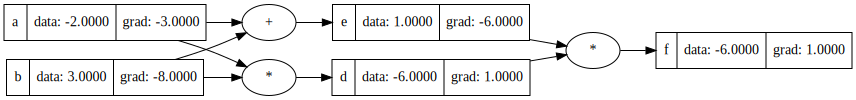

In [91]:
# another situation
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

if we see multivariable calc notes, we can tell the errors lies since we are assigning the gradient at as self.grad = out.grad * 1 


What we have to do is accumulate the sum of all the gradients self.grad += out.grad * 1